# tensorflow 高层API
从我们构建AlexNet模型可以看出,tensorflow在定义很多神经网络的基本单元的时候是比较复杂和冗长的.因此大部分时候人们都倾向于使用对tensorflow底层代码进行封装的高层api，比如keras,slim,tflearn,skflow等等.在这里,我们来分别使用keras和slim这两个非常流行的高层api尝试构造AlexNet

# Keras
>- 简易和快速的原型设计（keras具有高度模块化，极简，和可扩充特性）
>- 支持CNN和RNN，或二者的结合
>- 无缝CPU和GPU切换

>Keras的设计原则是

>- 用户友好：Keras是为人类而不是天顶星人设计的API。用户的使用体验始终是我们考虑的首要和中心内容。Keras遵循减少认知困难的最佳实践：Keras提供一致而简洁的API， 能够极大减少一般应用下用户的工作量，同时，Keras提供清晰和具有实践意义的bug反馈。
>- 模块性：模型可理解为一个层的序列或数据的运算图，完全可配置的模块可以用最少的代价自由组合在一起。具体而言，网络层、损失函数、优化器、初始化策略、激活函数、正则化方法都是独立的模块，你可以使用它们来构建自己的模型。
>- 易扩展性：添加新模块超级容易，只需要仿照现有的模块编写新的类或函数即可。创建新模块的便利性使得Keras更适合于先进的研究工作。
与Python协作：Keras没有单独的模型配置文件类型（作为对比，caffe有），模型由python代码描述，使其更紧凑和更易debug，并提供了扩展的便利性。

In [1]:
import keras
from utils import cifar10_input
from keras.datasets import cifar10

Using TensorFlow backend.


# 读取数据
Keras自带了cifar10数据集,并且自动分成了训练集和测试集

In [2]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()    

数据归一化

In [3]:
x_train = x_train.astype('float')
x_test = x_test.astype('float')

x_train /= 255
x_test /= 255

Keras的数据不需要转化成tensorflow下的tensor,可以直接作为网络的输入层

In [4]:
print((type(x_train), type(y_train)))
print((x_train.shape, y_train.shape))
print((x_test.shape, y_test.shape))

(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
((50000, 32, 32, 3), (50000, 1))
((10000, 32, 32, 3), (10000, 1))


# 构建Keras模型

## Keras网络层
Keras为了方便用户搭建神经网络模型, 把很多常用的层, 比如`Conv2d`, `MaxPooling2d`,封装起来, 使得输入更加简单明了.

## Keras模型
Keras提供`Sequential`和`Model`两种模型的构建方法, 使用他们搭建模型就像搭积木一样非常直观简单.


In [5]:
from keras.models import Sequential

model = Sequential()

从keras中导入我们需要的模块

In [6]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers import Activation

- 然后添加第一个卷积层, 卷积核为5x5x64, 步长为1x1, 激活函数是relu
- 注意, 添加第一个层的时候需要注明输入的形状是什么

In [7]:
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), 
                 input_shape=(32,32,3), activation='relu'))

- 添加第二个池化层, 核为3x3, 步长为2x2

In [8]:
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

- 第三个卷积层5x5x64,步长为1x1,激活是relu

In [9]:
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu'))

- 第四层是核大小3x3, 步长为2x2的池化层

In [10]:
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

- 将矩阵摊平成向量

In [11]:
model.add(Flatten())

- 全连接层, 输出为384维向量

In [12]:
model.add(Dense(units=384, activation='relu'))
model.add(Dense(units=192, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

现在我们已经完成了模型的搭建,.

`keras`还提供了很多方法帮助我们理解模型
- `model.summary()`
- `plot_model`

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 384)               393600    
_________________________________________________________________
dense_2 (Dense)              (None, 192)               73920     
__________

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='img/keras_alexnet.png')

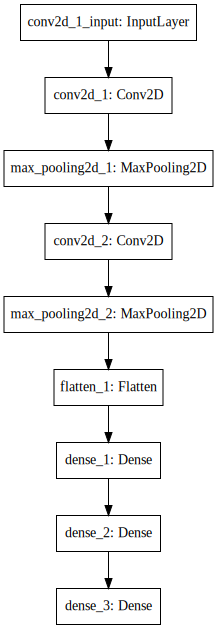

In [15]:
# 可视化模型
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# 模型编译
模型构建完成之后, 我们需要用compile来配置训练过程

model.compile()接受三个参数:
- optimizer: 优化方法, 有"sgd","rmsprop","adgrad"等这样的字符串, 也可以是keras.Optimizers对象
- loss: 损失函数, 有categorical_crossentropy, mes等这样的字符串, 也可以是函数形式
- metrics: 评价函数, 如['accuracy'], 也支持自定义

In [16]:
# 定义优化器
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9)

# 将标签转换one_hot形式
labels = keras.utils.to_categorical(y_train, num_classes=10)

In [17]:
model.compile(optimizer=sgd, 
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# 训练
keras训练模型非常简单, 用一个fit函数就可以搞定

In [18]:
model.fit(x=x_train, y=labels,
          epochs=25, batch_size=64)

Epoch 1/25
50000/50000 [==============================] - 21s 414us/step - loss: 1.6782 - acc: 0.3854
Epoch 2/25
50000/50000 [==============================] - 15s 307us/step - loss: 1.2516 - acc: 0.5541
Epoch 3/25
50000/50000 [==============================] - 15s 307us/step - loss: 1.0722 - acc: 0.6232
Epoch 4/25
50000/50000 [==============================] - 16s 318us/step - loss: 0.9375 - acc: 0.6720
Epoch 5/25
50000/50000 [==============================] - 16s 315us/step - loss: 0.8294 - acc: 0.7074
Epoch 6/25
50000/50000 [==============================] - 16s 319us/step - loss: 0.7405 - acc: 0.7386
Epoch 7/25
50000/50000 [==============================] - 17s 347us/step - loss: 0.6633 - acc: 0.7667
Epoch 8/25
50000/50000 [==============================] - 16s 323us/step - loss: 0.5912 - acc: 0.7899
Epoch 9/25
50000/50000 [==============================] - 17s 338us/step - loss: 0.5206 - acc: 0.8163
Epoch 10/25
50000/50000 [==============================] - 16s 319us/step - loss: 

# 评价
keras的评价也非常简单, 用一个evaluate就可以

In [19]:
model.evaluate(x_train,labels, batch_size=128)

50000/50000 [==============================] - 7s 134us/step


[0.11329674496173858, 0.96232]

In [20]:
onehot_test = keras.utils.to_categorical(y_test)
model.evaluate(x_test,onehot_test, batch_size=128)

10000/10000 [==============================] - 1s 135us/step


[1.8118828453063964, 0.6968]

# TF-slim
TF-Slim是一个可以在tensorflow中实现构建模型,训练模型,评估模型的轻量级代码库. 可以和原生的tensorflow或者其他例如tf.contrib.learn这样的框架自由组合.

In [21]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from utils import cifar10_input

In [22]:
batch_size = 64
data_dir = 'E:/data/cifar10_data/cifar-10-batches-bin'

train_imgs, train_labels = cifar10_input.inputs(eval_data=False,
                                                data_dir=data_dir,
                                                batch_size=batch_size,
                                                shuffle=True)

val_imgs, val_labels = cifar10_input.inputs(eval_data=True,
                                            data_dir=data_dir,
                                            batch_size=batch_size,
                                            shuffle=False)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.FixedLengthRecordDataset`.
Instructions for updating:
Q

# 构建模型

#### slim中的高级层
slim也对tensorflow的底层API进行了层的封装, 像Keras一样, 它也具有
- slim.conv2d
- slim.max_pool2d
- slim.flatten
- slim.fully_connected
- slim.batch_norm

等等高级层, 这些接口也是用户友好的, 例如slim.conv2d

第一个参数是输入, 第二个是输出大小, 也就是卷积核的个数, 第三个是卷积核大小, 是一个长度为2的向量, 后面还有很多默认参数,帮助我们快速定义一个卷积层,  可以说是非常简单了

# arg_scope
然后给大家介绍一个slim中独有也非常好用的一个功能: `slim.arg_scope()`

我们知道, 在构建模型的时候会遇到很多相同的参数, 比如说很多卷积层或者池化层的补零策略都是`"VALID"`或者`"SAME"`, 很多变量的初始化函数都是tf.truncated_normal_initializer或者tf.constant_initializer, 如果全部手动写就会显得非常麻烦. 

这个时候, 可以通过python的with语句和slim.arg_scope()构成一个参数域, 在这个域下一次性定义好所有函数的一些默认参数, 就会非常方便了
- - -
使用arg_scope分为两个步骤
- 定义你要对哪些函数使用默认参数
- 定义你要使用的默认参数的具体值

In [23]:
# 定义AlexNet默认参数域
def AlexNet_arg_scope():
    # 首先我们定义卷积和全连接层的参数域, 他们都用`tf.nn.relu`作为激活函数
    # 都用`tf.truncated_normal`作为权重的初始化函数
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                       activation_fn=tf.nn.relu,
                       weights_initializer=tf.truncated_normal_initializer(stddev=1e-2)):
        # 在参数域内部继续定义参数域, 这里, 我们注意到在`AlexNet`中
        # 卷积和池化的补零策略都是`VALID`
        with slim.arg_scope([slim.conv2d, slim.max_pool2d],
                           padding='VALID') as sc:
            return sc

In [24]:
# 定义alexnet模型
def AlexNet(inputs, reuse=None):
    with tf.variable_scope('AlexNet', reuse=reuse):
        net = slim.conv2d(inputs, 64, [5, 5], scope='conv1')
        net = slim.max_pool2d(net, [3, 3], scope='pool1')
        net = slim.conv2d(net, 64, [5, 5], scope='conv2')
        net = slim.max_pool2d(net, [3, 3], scope='pool2')
        net = slim.flatten(net)
        net = slim.fully_connected(net, 384, scope='fc3')
        net = slim.fully_connected(net, 192, scope='fc4')
        net = slim.fully_connected(net, 10, activation_fn=None, scope='classification')
        
        return net

In [25]:
with slim.arg_scope(AlexNet_arg_scope()):
    train_out = AlexNet(train_imgs)
    val_out = AlexNet(val_imgs, reuse=True)

# Slim 统计模型
Slim也有类似Keras的模型统计功能

In [26]:
vars_size, vars_bytes = slim.model_analyzer.analyze_vars(variables=tf.model_variables(), print_info=True)

---------
Variables: name (type shape) [size]
---------
AlexNet/conv1/weights:0 (float32_ref 5x5x3x64) [4800, bytes: 19200]
AlexNet/conv1/biases:0 (float32_ref 64) [64, bytes: 256]
AlexNet/conv2/weights:0 (float32_ref 5x5x64x64) [102400, bytes: 409600]
AlexNet/conv2/biases:0 (float32_ref 64) [64, bytes: 256]
AlexNet/fc3/weights:0 (float32_ref 1024x384) [393216, bytes: 1572864]
AlexNet/fc3/biases:0 (float32_ref 384) [384, bytes: 1536]
AlexNet/fc4/weights:0 (float32_ref 384x192) [73728, bytes: 294912]
AlexNet/fc4/biases:0 (float32_ref 192) [192, bytes: 768]
AlexNet/classification/weights:0 (float32_ref 192x10) [1920, bytes: 7680]
AlexNet/classification/biases:0 (float32_ref 10) [10, bytes: 40]
Total size of variables: 576778
Total bytes of variables: 2307112


# 训练
slim提供了简化训练的一些方法, 但是封装太多不够灵活, 如果想探究的话可以参考tf-slim的[官方说明](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim).

在这里我们还是回到之前用tensorflow定义好的训练函数进行训练

In [27]:
with tf.variable_scope('loss'):
    train_loss = tf.losses.sparse_softmax_cross_entropy(labels=train_labels, logits=train_out, scope='train')
    val_loss = tf.losses.sparse_softmax_cross_entropy(labels=val_labels, logits=val_out, scope='val')

In [28]:
with tf.name_scope('accuracy'):
    with tf.name_scope('train'):
        train_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(train_out, axis=-1, output_type=tf.int32), train_labels), tf.float32))
    with tf.name_scope('val'):
        val_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(val_out, axis=-1, output_type=tf.int32), val_labels), tf.float32))


In [29]:
lr = 0.01

opt = tf.train.MomentumOptimizer(lr, momentum=0.9)
train_op = opt.minimize(train_loss)

In [33]:
import time
import numpy as np

NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

BATCH_SIZE=64
def train(train_op, train_loss, train_acc, 
          val_loss, val_acc, 
          max_step, batch_size=BATCH_SIZE,
          train_log_step=1000, val_log_step=4000):
    """训练函数
      Args:
        train_op: 训练`op`
        train_loss: 训练集计算误差的`op`
        train_acc: 训练集计算正确率的`op`
        val_loss: 验证集计算误差的`op`
        val_acc: 验证集计算正确率的`op`
        max_step: 最大迭代步长
        batch_sise: 一个批次中样本的个数
        train_log_step: 每隔多少步进行一次训练集信息输出
        val_log_step: 每隔多少步进行一次验证集信息输出
    
      Return:
        None
      """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)
    
        try:
            _start = time.time()
            for step in range(max_step + 1):
                sess.run(train_op)

                if step % train_log_step == 0:
                    _end = time.time()
                    duration = _end - _start

                    train_loss_, train_acc_ = sess.run([train_loss, train_acc])

                    sec_per_batch = 1.0 * duration / train_log_step

                    print('[train]: step %d loss = %.4f acc = %.4f (%.4f / batch)' \
                      % (step, train_loss_, train_acc_, sec_per_batch))

                    _start = _end

                if step % val_log_step == 0:
                    val_loss_, val_acc_ = sess.run([val_loss, val_acc])
                    print('[val]: step %d loss = %.4f acc = %.4f' % (step, val_loss_, val_acc_))

            print('-------------------------Over all Result-------------------------')

            train_loss_, train_acc_ = _evaluation_no_bn(sess, train_loss, train_acc, NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN, batch_size)
            print('[TRAIN]: loss = %.4f acc = %.4f' % (train_loss_, train_acc_))

            val_loss_, val_acc_ = _evaluation_no_bn(sess, val_loss, val_acc, NUM_EXAMPLES_PER_EPOCH_FOR_EVAL, batch_size)
            print('[VAL]: loss = %.4f acc = %.4f' % (val_loss_, val_acc_))

        except tf.errors.OutOfRangeError:
            print('Epoch Limited. Done!')
        finally:
            coord.request_stop()
            coord.join(threads)

def _evaluation_no_bn(sess, loss_op, acc_op, num_examples, batch_size):
    max_steps = num_examples // batch_size
    losses = []
    accs = []
    for _ in range(max_steps):
        loss_value, acc_value = sess.run([loss_op, acc_op])
        losses.append(loss_value)
        accs.append(acc_value)

    mean_loss = np.array(losses, dtype=np.float32).mean()
    mean_acc = np.array(accs, dtype=np.float32).mean()

    return mean_loss, mean_acc

In [34]:
train(train_op, train_loss, train_acc, val_loss, val_acc, 20000, batch_size)

[train]: step 0 loss = 2.3025 acc = 0.1562 (0.0069 / batch)
[val]: step 0 loss = 2.3026 acc = 0.0469
[train]: step 1000 loss = 2.3061 acc = 0.0469 (0.0347 / batch)
[train]: step 2000 loss = 1.2406 acc = 0.5312 (0.0360 / batch)
[val]: step 2000 loss = 1.4333 acc = 0.4219
[train]: step 3000 loss = 1.2226 acc = 0.5312 (0.0374 / batch)
[train]: step 4000 loss = 1.0619 acc = 0.6406 (0.0410 / batch)
[val]: step 4000 loss = 0.9758 acc = 0.6875
[train]: step 5000 loss = 0.4562 acc = 0.8438 (0.0432 / batch)
-------------------------Over all Result-------------------------
[TRAIN]: loss = 0.6854 acc = 0.7619
[VAL]: loss = 0.8585 acc = 0.7119
